In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

Num_samples = 50 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

sigma_A = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

K_inf = 3 # take to be large for a good approximation to the IBP

Pi, Z, mu, A, X = vi.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = K_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(Num_samples, D, K_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_A, sigma_eps)

data_set = DataSet(X, K_approx, alpha, sigma_eps, sigma_A)

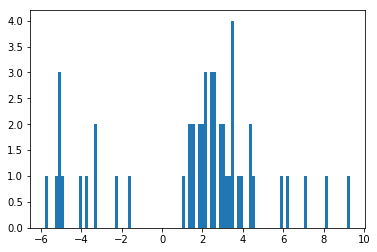

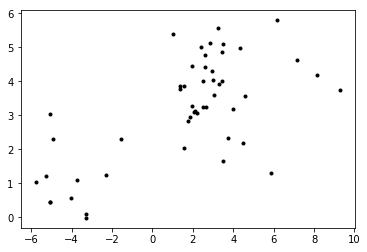

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(Pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
import time
par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(params_init, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time
print('Num samples: %d' % Num_samples)
print('Hessian time:')
print(par_hp_hess_time)

Num samples: 50
Hessian time:
0.0105719566345


In [6]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 KL: 41.8534069068
Step 10 KL: 3.45051908463
Step 20 KL: 0.159162515646
Step 30 KL: 0.0265090418965
Step 40 KL: 0.0107927490003
Step 50 KL: 0.00719883949159
Step 60 KL: 0.00456836858583
Step 70 KL: 0.00279784333309
Step 80 KL: 0.00169804920575
Step 90 KL: 0.00103270447534
Done.


In [7]:
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print np.all(np.isfinite(cavi_params))

True


In [8]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)

Step 0 KL: 511.498374275
Step 10 KL: -431.790915442
Step 20 KL: -564.298140474
Step 30 KL: -575.348822962
Step 40 KL: -578.416402528
Step 50 KL: -579.469662172
Step 60 KL: -579.636861312
Step 70 KL: -579.720747805
Optimization terminated successfully.
         Current function value: -579.720822
         Iterations: 74
         Function evaluations: 75
         Gradient evaluations: 69
         Hessian evaluations: 0
Done.


In [10]:
print 'CAVI:'
print cavi_phi_mu.transpose()

print 'Full TR:'
tau, phi_mu, phi_var, nu = data_set.unpack_params(vb_opt.x)
print phi_mu.transpose()

print 'Truth:'
print A



CAVI:
[[-1.05668408  1.74436466]
 [ 7.51729281  2.8171349 ]
 [-3.6987857  -0.64447995]]
Full TR:
[[-1.04123945  1.74669924]
 [ 7.5143773   2.81253843]
 [-3.7084741  -0.64521505]]
Truth:
[[-0.6611876   1.53579266]
 [-3.42847146 -0.34519728]
 [ 6.80726618  2.97401052]]


Cavi residuals: 69.3544864375    Trust residuals: 69.5860716837


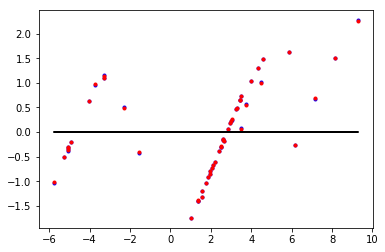

In [11]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(vb_opt.x)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}'.format(np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid))))
